In [141]:
import torch
from torch.utils.data import ConcatDataset, DataLoader, Dataset
import pickle
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as tmodels
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.cuda.device_count())  # 사용 가능한 GPU 개수
print(torch.cuda.get_device_name(0))  # 첫 번째 GPU 이름

1
NVIDIA GeForce RTX 4090


In [142]:
gnDataset = 3
gBase_path = '/home/kimw30/CAS771/Task2_data'
gnClasses = 5
gbData_augmentation = False
gData_batch_size = 32
gDropout_rate = 0.9

In [143]:
Flearning_rate = 0.00001
FEpoch = 30
FWeight_decay = 1e-4
FnClasses = 15
Finput_dim = 1280
FEarly_stop_patience = 3
FOpt_schedule_step = 10
FOpt_schedule_rate = 0.1
FSequential = False
FLog_path = '/home/kimw30/CAS771/TaskB/logs'
Ffusion_name =  'afwp' #'smpf' #'ieaf' #'acf' #'cf' #'afm' #'mhafm' #'ief' #'moefi' #'afwp'
FTest_dataset_num = 2

In [144]:
class CAS771Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform and not isinstance(img, torch.Tensor):
            img = self.transform(img)
        return img, label
    
def _load_data(train_data_path):
    raw_data = torch.load(train_data_path)
    data = raw_data['data']
    data = data.permute(0, 3, 1, 2)
    labels = raw_data['labels']
    labels = labels.tolist()
    return data, labels

def remap_labels(labels, class_mapping):
    return [class_mapping[label] for label in labels]

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_layers(model):
    layer_count = 0
    for module in model.children():
        if not isinstance(module, nn.Dropout):  # deduct Dropout
            layer_count += 1
    return layer_count

def get_model_instance(m = 0):
    model = torch.load(f"{gBase_path}/model{m+1}_all.pth")
    model.eval()
    print(f"Model{m+1} parameters: {count_parameters(model)}")
    print(f"Model{m+1} Total layers: {count_layers(model)}")
    return model

def load_models():
    models = [get_model_instance(m) for m in range(gnDataset)]
    return models

def save_model(model, m=0, all=False):
    if all == True:
        model_saved_path = f"{gBase_path}/model{m+1}_all.pth"
        torch.save(model, model_saved_path)
    else:
        model_saved_path = f"{gBase_path}/model{m+1}_weights.pth"
        torch.save(model.state_dict(), model_saved_path)

    print(f"Model{m+1} is saved to: {model_saved_path}")

def get_data_augmentation(mode):
    if gbData_augmentation == False:
        return None
    
    if mode == "train":
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(), # inverse left-right
            transforms.RandomRotation(degrees=15), # random rotate
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # random crop
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalization
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

def _load_mappings():
    mapping_files = [f'{gBase_path}/class_mapping_model_{m+1}.pkl' for m in range(gnDataset)]
    rtov_mappings = {}
    vtor_mappings = {}

    i = 0
    for file in mapping_files:
        with open(file, 'rb') as f:
            mapping = pickle.load(f)
        
        offset = gnClasses*i
        rtov_mappings |= {key: value + offset for key, value in mapping.items()}
        vtor_mappings |= {value + offset: key for key, value in mapping.items()}
        i = i+1
        
    return rtov_mappings, vtor_mappings

class CAS771EarlyStopping():
    def __init__(self):
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def isStop(self, validation_loss):
        if validation_loss < self.best_val_loss: # 검증 손실이 감소하면 best_val_loss 업데이트
            self.best_val_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1
        
        if self.patience_counter >= FEarly_stop_patience: # 검증 손실이 감소하지 않으면 학습 종료
            print("Early stopping")
            return True
        else:
            return False

In [145]:
class SimpleFusion(nn.Module):
    ''' smpf '''
    def __init__(self, input_dim=1280, hidden_dim=1024, num_models=3, output_dim=15):
        super(SimpleFusion, self).__init__()
        self.fc1 = nn.Linear(input_dim * num_models, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, inputs):
        x = torch.cat(inputs, dim=1)  # (batch_size, 3 * 1280)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [146]:
class CombinedFusion(nn.Module):
    ''' cf '''
    def __init__(self, input_dim=1280, output_dim_per_model=5, num_models=3, hidden_dim=1024, final_output_dim=15):
        super(CombinedFusion, self).__init__()
        self.num_models = num_models
        
        # 임베딩 차원 축소 (선택적)
        self.embed_proj = nn.Linear(input_dim, 256)  # 1280 -> 256으로 압축
        
        # 결합 후 입력 크기: (256 + 5) * 3 = 783
        combined_input_dim = (256 + output_dim_per_model) * num_models
        self.fc1 = nn.Linear(combined_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, final_output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, embeddings, outputs):
        # embeddings: [emb1, emb2, emb3], 각 (batch_size, 1280)
        # outputs: [out1, out2, out3], 각 (batch_size, 5) (로짓)
        
        # 임베딩 차원 축소
        proj_embs = [F.relu(self.embed_proj(emb)) for emb in embeddings]  # [(batch_size, 256)] * 3
        
        # 임베딩과 출력 연결
        combined_inputs = [torch.cat([proj_emb, out], dim=1) for proj_emb, out in zip(proj_embs, outputs)]
        # [(batch_size, 256 + 5)] * 3
        
        # 모든 모델의 입력 결합
        x = torch.cat(combined_inputs, dim=1)  # (batch_size, 783)
        
        # 분류
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [147]:
class AttentionCombinedFusion(nn.Module):
    ''' acf '''
    def __init__(self, input_dim=1280, output_dim_per_model=5, num_models=3, hidden_dim=1024, final_output_dim=15):
        super(AttentionCombinedFusion, self).__init__()
        self.num_models = num_models
        
        # 임베딩과 출력의 차원 축소
        self.embed_proj = nn.Linear(input_dim, hidden_dim)  # 1280 -> 512
        self.output_proj = nn.Linear(output_dim_per_model, hidden_dim)  # 5 -> 512
        
        # Attention 레이어
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4)
        
        # 최종 분류
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, final_output_dim)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, embeddings, outputs):
        # embeddings: [emb1, emb2, emb3], 각 (batch_size, 1280)
        # outputs: [out1, out2, out3], 각 (batch_size, 5) (로짓)
        
        # 차원 맞추기
        proj_embs = [F.relu(self.embed_proj(emb)) for emb in embeddings]  # [(batch_size, 512)] * 3
        proj_outs = [F.relu(self.output_proj(out)) for out in outputs]  # [(batch_size, 512)] * 3
        
        # 모든 입력 결합 (임베딩 + 출력)
        all_inputs = proj_embs + proj_outs  # [(batch_size, 512)] * 6
        x = torch.stack(all_inputs, dim=0)  # (6, batch_size, 512)
        
        # Multi-Head Attention 적용
        attn_output, _ = self.attention(x, x, x)  # (6, batch_size, 512)
        combined = torch.mean(attn_output, dim=0)  # (batch_size, 512)
        
        # 분류
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [148]:
class ImageEmbedFusion(nn.Module):
    ''' ief '''
    def __init__(self, input_dim=1280, num_models=3, img_channels=3, img_size=64, hidden_dim=1024, output_dim=15):
        super(ImageEmbedFusion, self).__init__()
        self.num_models = num_models
        self.embed_dim = input_dim
        self.hidden_dim = hidden_dim
        
        # 이미지 처리 CNN 블록
        self.img_conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (batch_size, 64, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (batch_size, 128, 16, 16)
            nn.Flatten(),     # (batch_size, 128 * 16 * 16)
            nn.Linear(128 * (img_size // 4) * (img_size // 4), hidden_dim)  # 32768 -> 512
        )
        
        # 결합 입력 크기: (hidden_dim * num_models) + hidden_dim
        combined_dim = hidden_dim * (num_models + 1)  # 3개 임베딩 + 이미지 벡터
        self.fc1 = nn.Linear(combined_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.7)

        self.red_linear = nn.Linear(input_dim, hidden_dim)
    
    def forward(self, embeddings, image):
        # embeddings: [emb1, emb2, emb3], 각 (batch_size, 1280)
        # image: (batch_size, 3, 64, 64)
        
        # 이미지 특징 추출
        img_features = self.img_conv(image)  # (batch_size, 512)
        
        # 임베딩 차원 축소 (선택적)
        proj_embs = [F.relu(self.red_linear(emb)) for emb in embeddings]  # [(batch_size, 512)] * 3
        
        # 모든 입력 결합
        all_inputs = proj_embs + [img_features]  # [(batch_size, 512)] * 4
        x = torch.cat(all_inputs, dim=1)  # (batch_size, 2048)
        
        # 분류
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [149]:
class ImageEmbedAttentionFusion(nn.Module):
    ''' ieaf '''
    def __init__(self, input_dim=1280, num_models=3, img_channels=3, img_size=64, hidden_dim=1024, output_dim=15):
        super(ImageEmbedAttentionFusion, self).__init__()
        self.num_models = num_models
        
        # 이미지 처리 CNN 블록
        self.img_conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (batch_size, 64, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (batch_size, 128, 16, 16)
            nn.Flatten(),     # (batch_size, 128 * 16 * 16)
            nn.Linear(128 * (img_size // 4) * (img_size // 4), hidden_dim)  # 32768 -> 512
        )
        
        # 임베딩 차원 축소
        self.embed_proj = nn.Linear(input_dim, hidden_dim)  # 1280 -> 512
        
        # Multi-Head Attention
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4)
        
        # 분류 레이어
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, embeddings, image):
        # embeddings: [emb1, emb2, emb3], 각 (batch_size, 1280)
        # image: (batch_size, 3, 64, 64)
        
        # 이미지 특징 추출
        img_features = self.img_conv(image)  # (batch_size, 512)
        
        # 임베딩 차원 축소
        proj_embs = [F.relu(self.embed_proj(emb)) for emb in embeddings]  # [(batch_size, 512)] * 3
        
        # 모든 입력 결합
        all_inputs = proj_embs + [img_features]  # [(batch_size, 512)] * 4
        x = torch.stack(all_inputs, dim=0)  # (4, batch_size, 512)
        
        # Attention 적용
        attn_output, _ = self.attention(x, x, x)  # (4, batch_size, 512)
        combined = torch.mean(attn_output, dim=0)  # (batch_size, 512)
        
        # 분류
        x = F.relu(self.fc1(combined))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [150]:
class AttentionFusion(nn.Module):
    ''' afm '''
    def __init__(self, input_dim=1280, num_models=3, hidden_dim=1024, output_dim=15):
        super(AttentionFusion, self).__init__()
        self.num_models = num_models
        
        # Attention 스코어 계산을 위한 레이어
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)  # 각 임베딩에 스칼라 스코어 부여
        )
        
        # 최종 분류를 위한 레이어
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # 결합된 임베딩 압축
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, inputs):
        # inputs: [emb1, emb2, emb3], 각 (batch_size, input_dim)
        
        # Attention 스코어 계산
        attention_scores = [self.attention(emb) for emb in inputs]  # [(batch_size, 1)] * 3
        attention_scores = torch.cat(attention_scores, dim=1)  # (batch_size, 3)
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, 3)
        
        # 가중합으로 임베딩 결합
        weighted_embs = torch.stack(inputs, dim=1)  # (batch_size, 3, input_dim)
        attention_weights = attention_weights.unsqueeze(2)  # (batch_size, 3, 1)
        combined_emb = torch.sum(weighted_embs * attention_weights, dim=1)  # (batch_size, input_dim)
        
        # 최종 분류
        x = F.relu(self.fc1(combined_emb))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [151]:
class AttentionFusionWithPretrained(nn.Module):
    ''' afwp '''
    def __init__(self, input_dim=1280, pretrained_embed_dim=2048, num_models=3, hidden_dim=512, output_dim=15):
        super(AttentionFusionWithPretrained, self).__init__()
        self.num_models = num_models
        
        # Pre-trained 모델 (ResNet50)
        self.pretrained_model = tmodels.resnet50(pretrained=True).to(device)
        self.pretrained_model.eval()
        self.pretrained_model = nn.Sequential(*list(self.pretrained_model.children())[:-1])  # (batch_size, 2048, 1, 1)
        
        # 차원 맞춤 레이어
        self.custom_proj = nn.Linear(input_dim, hidden_dim)  # 1280 -> 512
        self.pretrained_proj = nn.Linear(pretrained_embed_dim, hidden_dim)  # 2048 -> 512
        
        # Attention (Multi-Head로 업그레이드)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4)
        self.norm = nn.LayerNorm(hidden_dim)
        
        # 분류 레이어
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, custom_embeds, image):
        # custom_embeds: [emb1, emb2, emb3], 각 (batch_size, 1280)
        # image: (batch_size, 3, 224, 224) (ResNet50 입력 크기)
        
        # Pre-trained 모델로 임베딩 추출
        with torch.no_grad():
            pretrained_emb = self.pretrained_model(image)  # (batch_size, 2048, 1, 1)
            pretrained_emb = pretrained_emb.view(pretrained_emb.size(0), -1)  # (batch_size, 2048)
        
        # 차원 맞춤
        proj_custom_embs = [F.relu(self.custom_proj(emb)) for emb in custom_embeds]  # [(batch_size, 512)] * 3
        proj_pretrained_emb = F.relu(self.pretrained_proj(pretrained_emb))  # (batch_size, 512)
        
        # 모든 임베딩 결합
        all_embeds = proj_custom_embs + [proj_pretrained_emb]  # [(batch_size, 512)] * 4
        x = torch.stack(all_embeds, dim=0)  # (4, batch_size, 512)
        
        # Multi-Head Attention
        attn_output, attn_weights = self.attention(x, x, x)  # (4, batch_size, 512)
        attn_output = self.norm(attn_output)
        combined_emb = torch.mean(attn_output, dim=0)  # (batch_size, 512)
        
        # 분류
        x = F.relu(self.fc1(combined_emb))
        x = self.dropout(x)
        x = self.fc2(x)
        return x, attn_weights

In [152]:
class MultiheadAttentionFusion(nn.Module):
    ''' mhafm '''
    def __init__(self, input_dim=1280, num_models=3, hidden_dim=1024, output_dim=15):
        super(MultiheadAttentionFusion, self).__init__()
        self.num_models = num_models
        
        # Multi-Head Attention
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=4)
        self.norm = nn.LayerNorm(input_dim)
        
        # 분류 레이어
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, inputs):
        # inputs: [emb1, emb2, emb3], 각 (batch_size, 1280)
        x = torch.stack(inputs, dim=0)  # (3, batch_size, 1280)
        
        # Multi-Head Attention
        attn_output, _ = self.attention(x, x, x)  # (3, batch_size, 1280)
        attn_output = self.norm(attn_output)
        combined_emb = torch.mean(attn_output, dim=0)  # (batch_size, 1280)
        
        # 분류
        x = F.relu(self.fc1(combined_emb))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [153]:
class MoE_Fusion_Indv(nn.Module):
    ''' moefi '''
    def __init__(self, input_dims, num_experts=3, hidden_dim=1280, output_dim=FnClasses, dropout_rate=0.5):  # output_dim 가정, dropout 추가
        super(MoE_Fusion_Indv, self).__init__()
        
        self.num_experts = num_experts
        self.input_dims = input_dims  # 각 입력 임베딩 벡터의 차원 리스트
        self.dropout_rate = dropout_rate
        
        # 각 입력에 대한 게이팅 네트워크
        self.gates = nn.ModuleList([
            nn.Linear(input_dim, num_experts) for input_dim in self.input_dims
        ])
        
        # 각 입력에 대한 전문가 네트워크
        self.experts = nn.ModuleList([
            nn.ModuleList([
              nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),

                
                #nn.Linear(hidden_dim, hidden_dim),  # 추가된 Hidden Layer
                #nn.BatchNorm1d(hidden_dim),        # 추가된 Batch Norm
                #nn.ReLU(),                          # 추가된 ReLU
                #nn.Dropout(dropout_rate),          # 추가된 Dropout
                

                nn.Linear(hidden_dim, output_dim)
                ) for _ in range(num_experts)
            ]) for input_dim in self.input_dims
        ])
        self.final_cls = nn.Linear(num_experts * output_dim, 15)
    
    def forward(self, inputs):  # inputs는 세 임베딩의 리스트
        
        # 각 입력에 대한 전문가 출력 계산
        expert_outputs_all = []
        for i, input_vector in enumerate(inputs):
            # 게이팅 네트워크 계산
            gate_scores = F.softmax(self.gates[i](input_vector), dim=1)  # (batch_size, num_experts)

            # 전문가 네트워크 계산
            expert_outputs = torch.stack([expert(input_vector) for expert in self.experts[i]], dim=1)  # (batch_size, num_experts, output_dim)

            # 게이팅 가중치 적용
            gated_output = torch.sum(gate_scores.unsqueeze(2) * expert_outputs, dim=1)  # (batch_size, output_dim)
            expert_outputs_all.append(gated_output)

        # 연결 후 추가 레이어
        combined = torch.cat(expert_outputs_all, dim=1)  # (batch_size, 3 * output_dim)
        final_output = self.final_cls(combined)  # 15개 클래스
        return final_output

In [154]:
class CNN2(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 64, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=7, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        
        # Calculate the flattened size by passing dummy input
        dummy_input = torch.randn(1, 3, 64, 64)
        dummy_output = self.pool2(self.bn3(self.conv3(self.pool1(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(dummy_input))))))))))
        flattened_size = dummy_output.view(1, -1).size(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 1280)
        self.fc2 = nn.Linear(1280, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
       
    def forward(self, x, return_embedding=False):
        # Convolutional layer + ReLU + Batch Normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x) # first pooling
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x) # second pooling
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers + Dropout
        x = self.dropout(F.relu(self.fc1(x)))

        if return_embedding:
            return x  # Feature vector 반환

        x = self.fc2(x)
        return x

In [155]:
class CAS771Plot_E():
    def __init__(self, model, criterion, device, train_dataloader, test_dataloader, model_num, pre_models):
        self.model = model
        self.criterion = criterion 
        self.device = device
        self.train_losses = []
        self.validation_losses = []
        self.validation_accuracies = []
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.running_loss = 0.0
        self.model_num = model_num + 1
        self.pre_models = pre_models
    
    def init_running_loss(self):
        self.running_loss = 0.0

    def add_loss(self, loss):
        self.running_loss += loss

    def append(self, epoch):
        train_loss = self.running_loss / len(self.train_dataloader)
        validation_loss, validation_accuracy = self._validate()
        self.train_losses.append(train_loss)
        self.validation_losses.append(validation_loss)
        self.validation_accuracies.append(validation_accuracy)
        self._print(epoch, train_loss, validation_loss, validation_accuracy)
        return validation_loss

    def plot(self):
        self._plot_metrics(self.train_losses, self.validation_losses, self.validation_accuracies, self.model_num)
    
    def _print(self, epoch, train_loss, validation_loss, validation_accuracy):
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

    def _validate(self):
        self.model.eval()  # evaluation mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        attn_weights_list = []

        # 시각화를 위한 샘플 저장
        sample_images = []
        sample_ground_truths = []
        sample_predictions = []
        sample_count = 0
        max_samples = 10  # 시각화할 샘플 수

        with torch.no_grad():  # disable gradient calculations
            for inputs, labels in self.test_dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # afwp 모드에서 전처리 전 원본 이미지 저장
                if Ffusion_name == 'afwp':
                    original_inputs = inputs.clone()  # 원본 이미지 복사

                embeddings = []
                poutputs = []
                for model in models:
                    embedding = model(inputs, return_embedding=True).to(device)
                    embeddings.append(embedding)
                    if Ffusion_name == 'cf':
                        poutput = model(inputs, return_embedding=False).to(device)
                        poutputs.append(poutput)

                if FSequential == True:
                    for emb in embeddings:
                        # Fusion Network에 입력
                        outputs = fusion_model(emb)
                        loss = criterion(outputs, labels)
                        running_loss += loss.item()

                        _, predicted = torch.max(outputs, 1)
                        total_samples += labels.size(0)
                        correct_predictions += (predicted == labels).sum().item()
                else:
                    # Fusion Network에 입력
                    if Ffusion_name == 'ief' or Ffusion_name == 'ieaf' or Ffusion_name == 'afwp':
                        if Ffusion_name == 'afwp':
                            preprocess = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])
                            inputs = preprocess(inputs)
                        outputs, _ = fusion_model(embeddings, inputs)
                    elif Ffusion_name == 'cf' or Ffusion_name == 'acf':
                        outputs = fusion_model(embeddings, poutputs)
                    else:
                        outputs = fusion_model(embeddings)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_samples += labels.size(0)
                    correct_predictions += (predicted == labels).sum().item()    

                    # 시각화를 위한 샘플 수집
                    if sample_count < max_samples:
                        batch_size = inputs.size(0)
                        for i in range(batch_size):
                            if sample_count < max_samples:
                                # afwp 모드에서는 원본 이미지를 사용
                                if Ffusion_name == 'afwp':
                                    sample_images.append(original_inputs[i].cpu())
                                else:
                                    sample_images.append(inputs[i].cpu())
                                sample_ground_truths.append(labels[i].cpu().item())
                                sample_predictions.append(predicted[i].cpu().item())
                                sample_count += 1
                            else:
                                break

        validation_loss = running_loss / len(self.test_dataloader)
        validation_accuracy = correct_predictions / total_samples

        # 클래스 이름 (15개 클래스 가정, 실제 클래스 이름으로 대체 필요)
        class_names = [f"Class {i}" for i in range(15)]  # 예: ['Class 0', 'Class 1', ..., 'Class 11']

        # 이미지 시각화
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()

        for idx in range(min(len(sample_images), max_samples)):
            image = sample_images[idx]
            ground_truth = sample_ground_truths[idx]
            prediction = sample_predictions[idx]

            # 이미지 처리
            image = image.permute(1, 2, 0).numpy()  # (H, W, C)로 변환

            # 값 범위 조정 (display_images 참고)
            # 데이터 로더에서 이미지가 0~1 범위로 제공되었다고 가정
            if image.max() <= 1.0:  # 0~1 범위일 경우
                image = image * 255.0  # 0~255로 스케일링
            image = image.astype(np.uint8)  # uint8로 변환 (display_images와 동일)

            # 이미지 표시
            axes[idx].imshow(image)
            axes[idx].axis('off')
            # Ground Truth와 Predicted 표시
            title = f"GT: {class_names[ground_truth]}\nPred: {class_names[prediction]}"
            axes[idx].set_title(title, fontsize=10, pad=5)

        plt.tight_layout()
        plt.show()

        return validation_loss, validation_accuracy

    def _plot_metrics(self, train_losses, validation_losses, validation_accuracies, model_num):
        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs, validation_losses, label='Validation Loss', marker='o')
        plt.title(f'Model {model_num} Learning per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy', marker='o', color='green')
        plt.title(f'Model {model_num} Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show() 

In [156]:
def get_fusion_model(fusion_model_name, input_dim):
    if fusion_model_name == 'smpf':
        model = SimpleFusion(input_dim=input_dim).to(device)
    elif fusion_model_name == 'moefi':
        model = MoE_Fusion_Indv(input_dims=[Finput_dim]*3, dropout_rate=0.2).to(device)
    elif fusion_model_name == 'afm':
        model = AttentionFusion(input_dim=input_dim).to(device)
    elif fusion_model_name == 'afm2':
        model = AttentionFusion2(input_dim=input_dim).to(device)
    elif fusion_model_name == 'afwp':
        model = AttentionFusionWithPretrained(input_dim=1280).to(device)
    elif fusion_model_name == 'mhafm':
        model = MultiheadAttentionFusion(input_dim=input_dim).to(device)
    elif fusion_model_name == 'ief':
        model = ImageEmbedFusion(input_dim=input_dim).to(device)
    elif fusion_model_name == 'ieaf':
        model = ImageEmbedAttentionFusion(input_dim=input_dim).to(device)
    elif fusion_model_name == 'cf':
        model = CombinedFusion(input_dim=input_dim).to(device)
    elif fusion_model_name == 'acf':
        model = AttentionCombinedFusion(input_dim=input_dim).to(device)
    
    print(f"Fusion Model parameters: {count_parameters(model)}")
    print(f"FusionModel Total layers: {count_layers(model)}")

    optimizer = torch.optim.Adam(model.parameters(), lr=Flearning_rate, weight_decay=FWeight_decay)
    criterion = nn.CrossEntropyLoss()

    return model, optimizer, criterion

In [157]:
def get_cas771plot(model, criterion, device, train_dataloader, test_dataloader, model_num, pre_models, fusion_model_name):
    progress = CAS771Plot_E(model, criterion, device, train_dataloader, test_dataloader, model_num, pre_models)
    return progress 

In [158]:
train_data_paths = [f'{gBase_path}/train_dataB_model_{i}.pth' for i in range(1, gnDataset+1)]
test_data_paths = [f'{gBase_path}/val_dataB_model_{i}.pth' for i in range(1, gnDataset+1)]

In [159]:
def _load_combined_dataset_moefi():
    rtov_mappings, vtor_mappings = _load_mappings()

    train_dataset = []
    test_dataset = []
    for m in range(gnDataset):
        train_data, train_labels = _load_data(train_data_paths[m])
        train_remapped_labels = remap_labels(train_labels, rtov_mappings)
        _train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=None)
        #_train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)
        train_dataset.append(_train_dataset)

    test_data, test_labels = _load_data(test_data_paths[FTest_dataset_num])
    test_remapped_labels = remap_labels(test_labels, rtov_mappings)
    transform = get_data_augmentation("test")
    _test_dataset = CAS771Dataset(test_data, test_remapped_labels, transform=transform)
    #_test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)
    test_dataset.append(_test_dataset)

    # 데이터셋 합치기
    combined_train_dataset = ConcatDataset(train_dataset)
    combined_test_dataset = ConcatDataset(test_dataset)

    # DataLoader 생성
    train_dataloader = DataLoader(combined_train_dataset, batch_size=gData_batch_size, shuffle=True)
    test_dataloader = DataLoader(combined_test_dataset, batch_size=gData_batch_size, shuffle=True)

    return train_dataloader, test_dataloader

def _load_combined_dataset_moef():
    rtov_mappings, vtor_mappings = _load_mappings()

    train_dataset = []
    test_dataset = []
    for m in range(gnDataset):
        train_data, train_labels = _load_data(train_data_paths[m])
        train_remapped_labels = remap_labels(train_labels, rtov_mappings)
        _train_dataset = CAS771Dataset(train_data, train_remapped_labels, transform=None)
        #_train_dataloader = DataLoader(train_dataset, batch_size=gData_batch_size, shuffle=True)

        test_data, test_labels = _load_data(test_data_paths[m])
        test_remapped_labels = remap_labels(test_labels, rtov_mappings)
        transform = get_data_augmentation("test")
        _test_dataset = CAS771Dataset(test_data, test_remapped_labels, transform=transform)
        #_test_dataloader = DataLoader(test_dataset, batch_size=gData_batch_size, shuffle=False)
        
        train_dataset.append(_train_dataset)
        test_dataset.append(_test_dataset)

    # 데이터셋 합치기
    combined_train_dataset = ConcatDataset(train_dataset)
    combined_test_dataset = ConcatDataset(test_dataset)

    # DataLoader 생성
    train_dataloader = DataLoader(combined_train_dataset, batch_size=gData_batch_size, shuffle=True)
    test_dataloader = DataLoader(combined_test_dataset, batch_size=gData_batch_size, shuffle=True)

    return train_dataloader, test_dataloader

def load_combined_dataset():
    if Ffusion_name == 'moef':
        return _load_combined_dataset_moef()
    else:
        return _load_combined_dataset_moef()
        #return _load_combined_dataset_moefi()      

Model1 parameters: 7447845
Model1 Total layers: 10
Model2 parameters: 7447845
Model2 Total layers: 10
Model3 parameters: 7447845
Model3 Total layers: 10


/home/kimw30/programs/anaconda3/envs/cas771/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kimw30/programs/anaconda3/envs/cas771/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fusion Model parameters: 26534991
FusionModel Total layers: 7


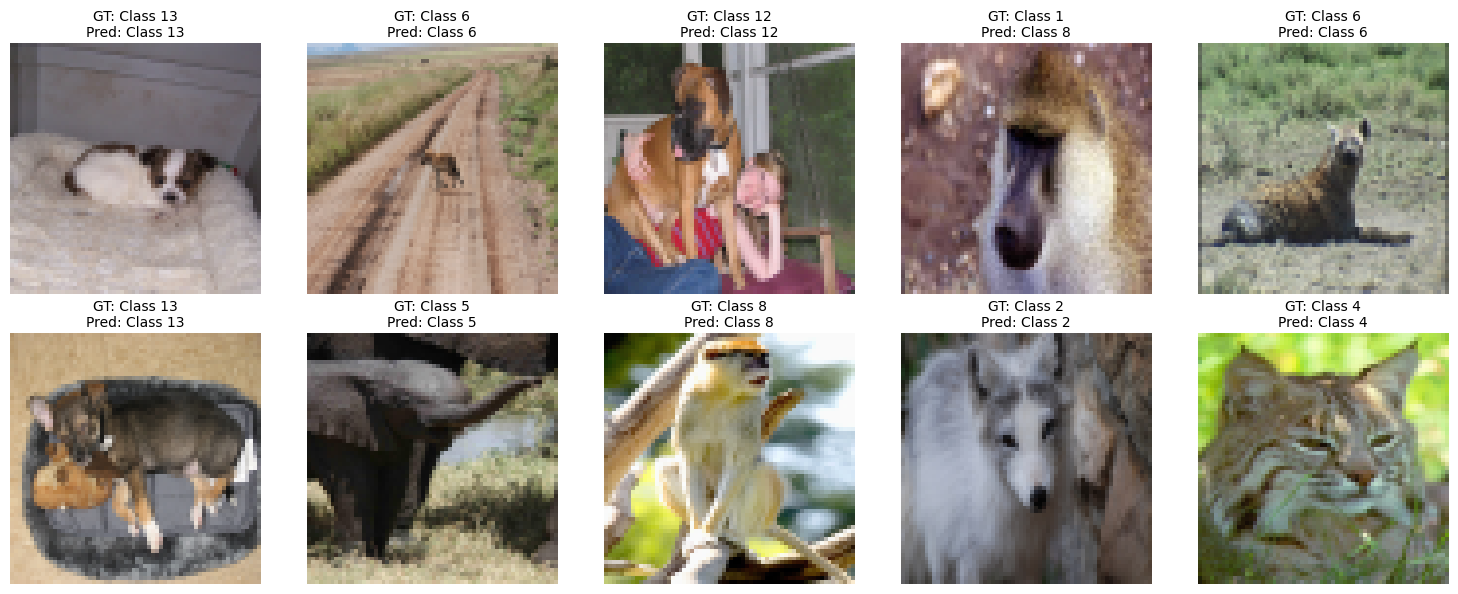

Epoch 1, Train Loss: 1.7179, Validation Loss: 1.0187, Validation Accuracy: 0.8000


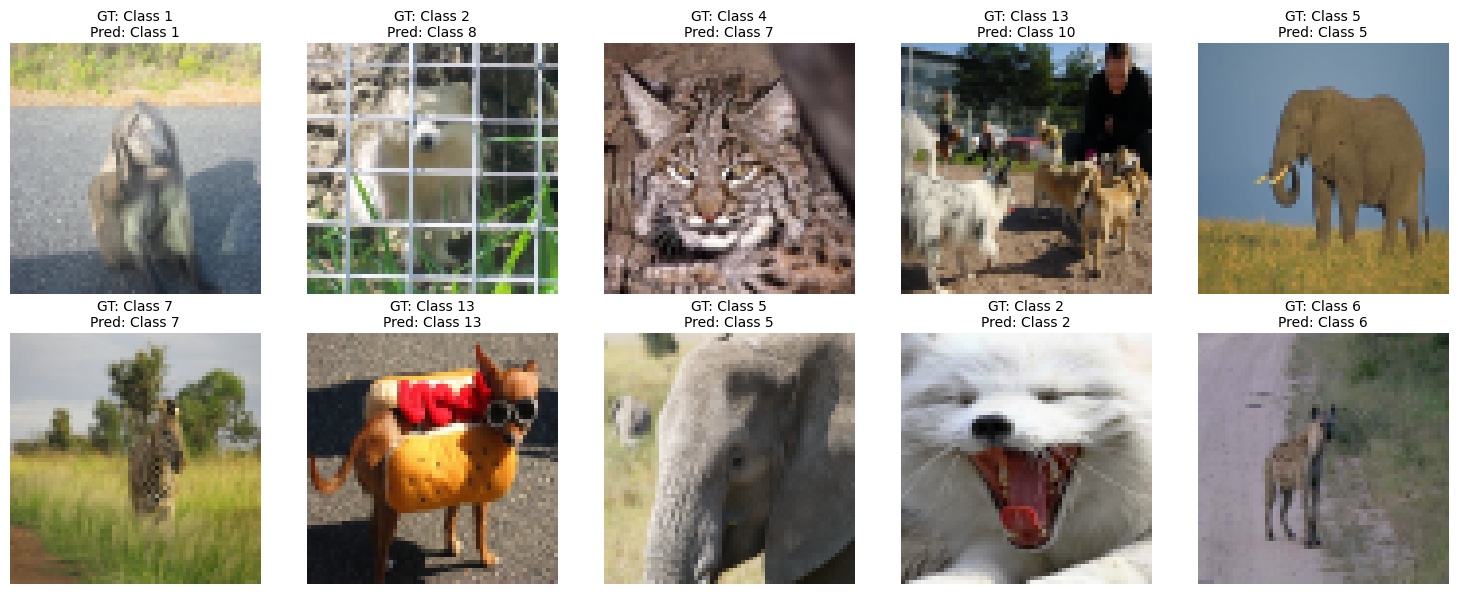

Epoch 2, Train Loss: 0.6930, Validation Loss: 0.5425, Validation Accuracy: 0.8693


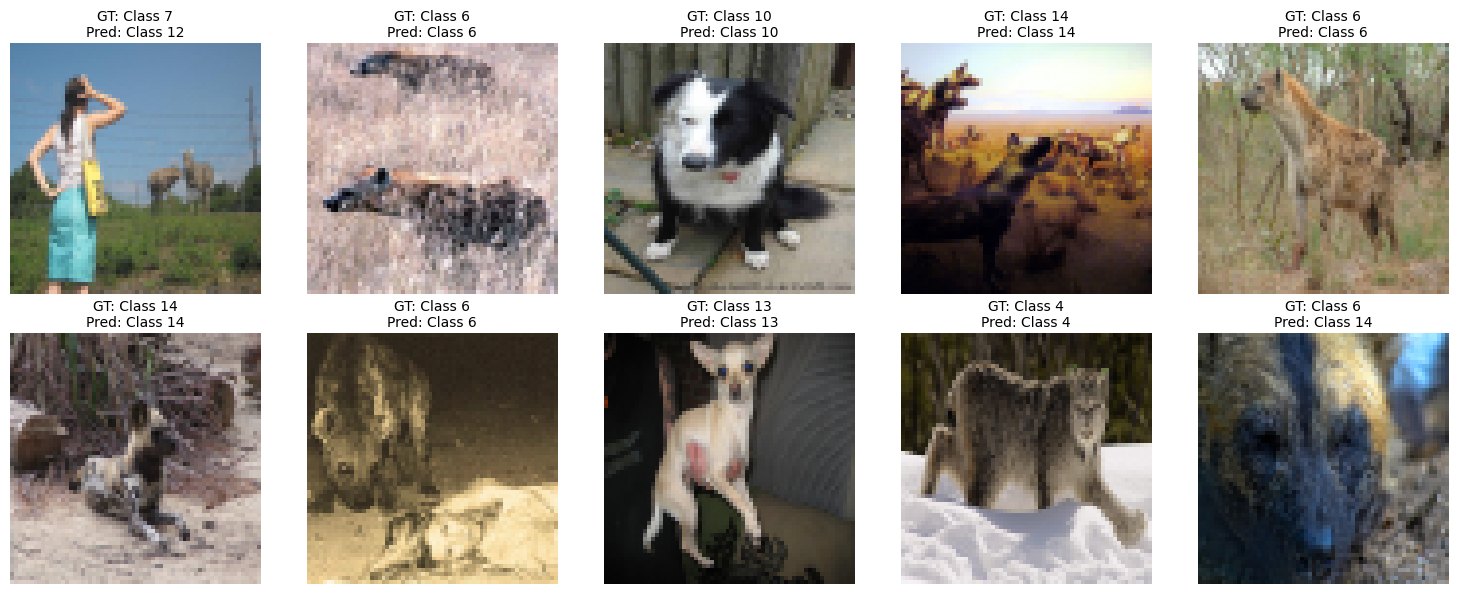

Epoch 3, Train Loss: 0.4310, Validation Loss: 0.4172, Validation Accuracy: 0.8760


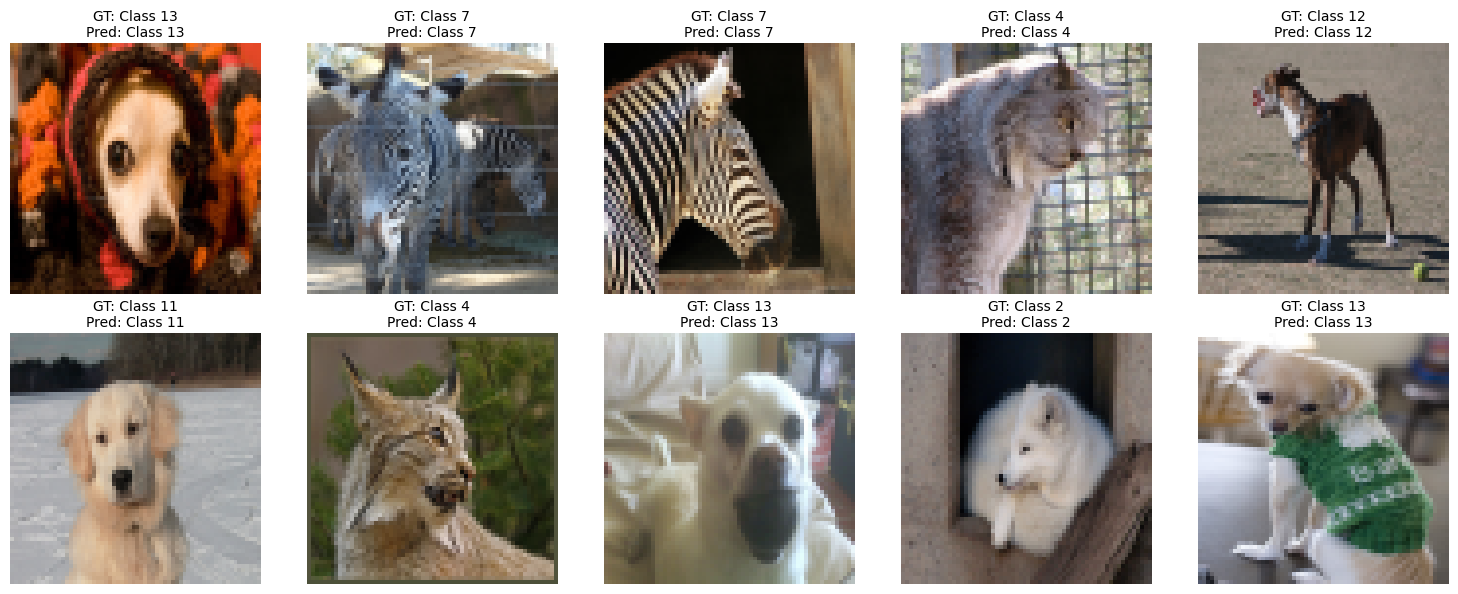

Epoch 4, Train Loss: 0.3396, Validation Loss: 0.3821, Validation Accuracy: 0.8800


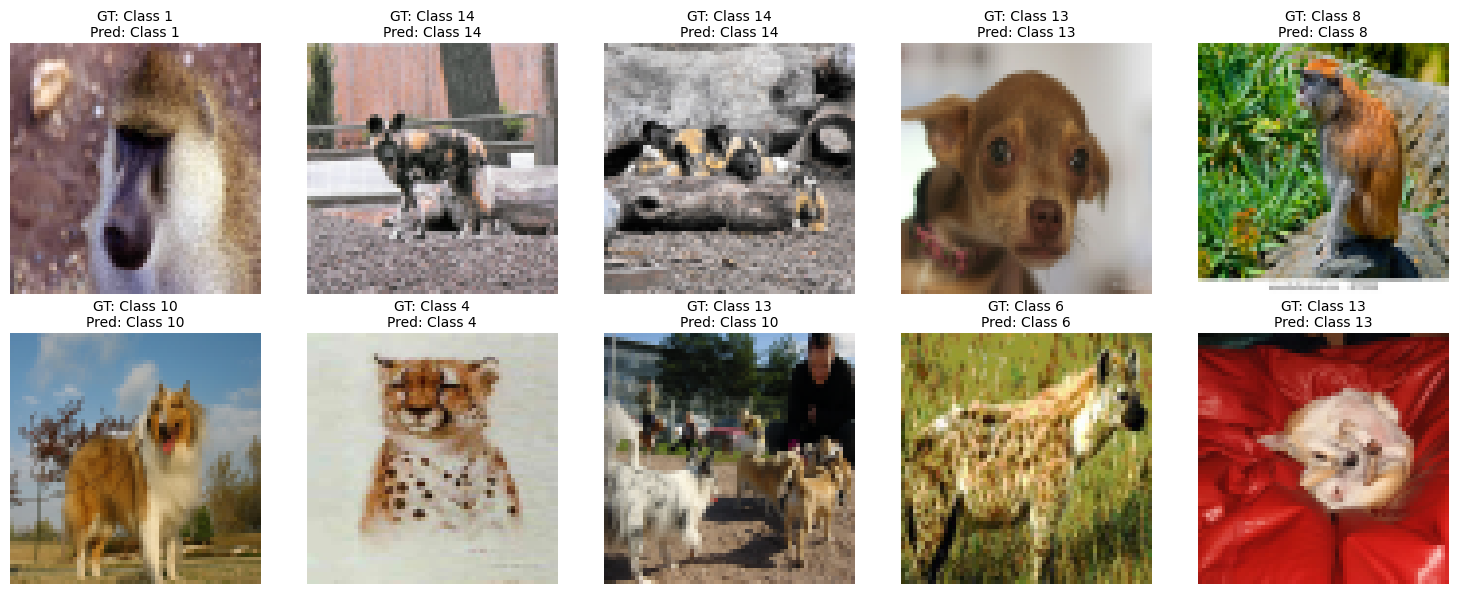

Epoch 5, Train Loss: 0.2810, Validation Loss: 0.3818, Validation Accuracy: 0.8827


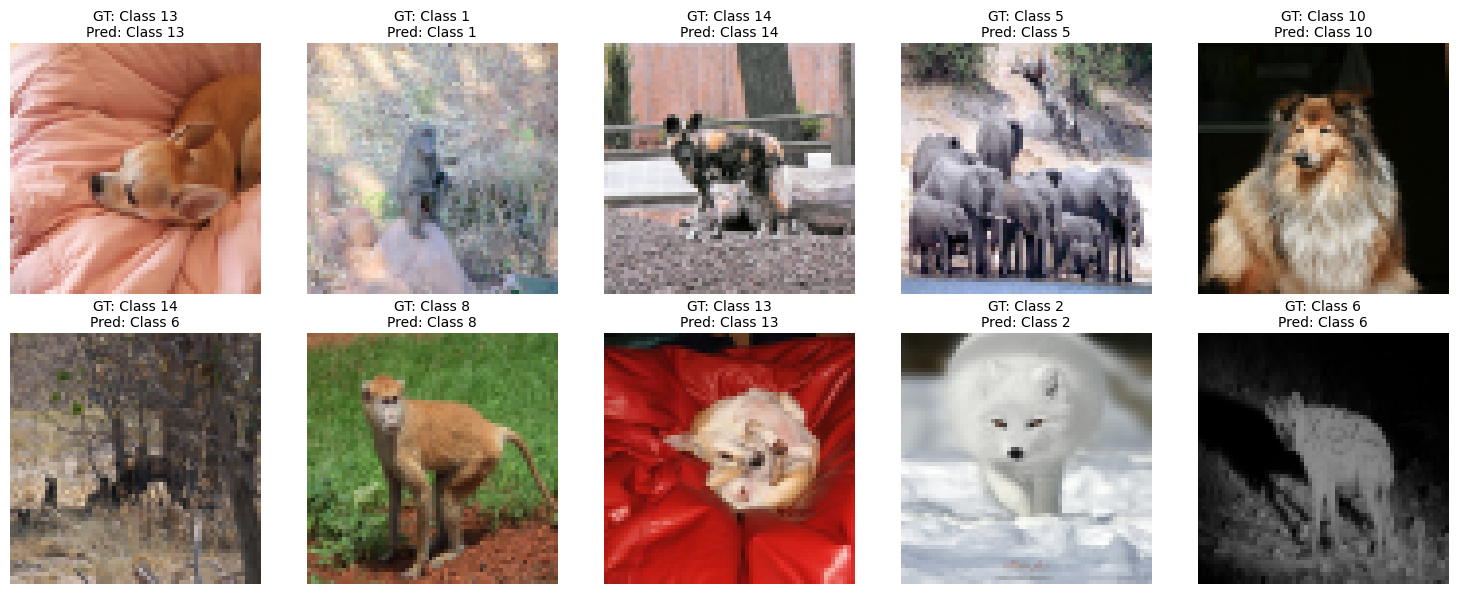

Epoch 6, Train Loss: 0.2447, Validation Loss: 0.3826, Validation Accuracy: 0.8840


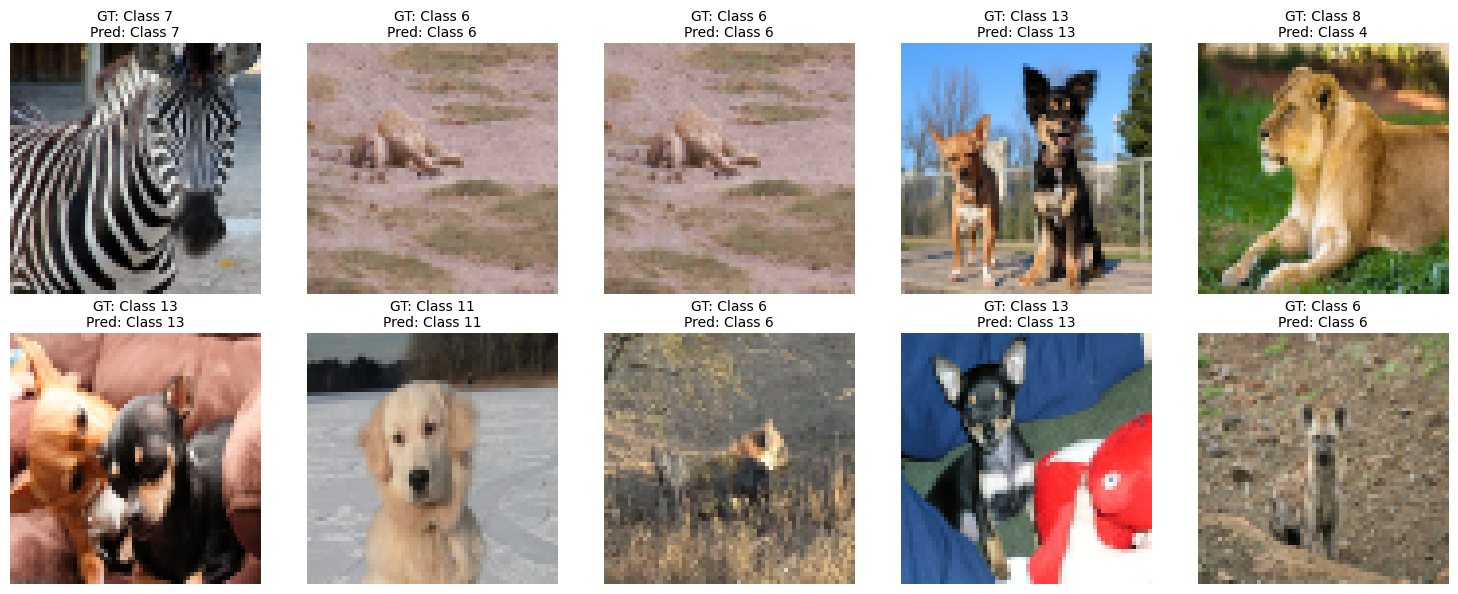

Epoch 7, Train Loss: 0.2155, Validation Loss: 0.3613, Validation Accuracy: 0.8853


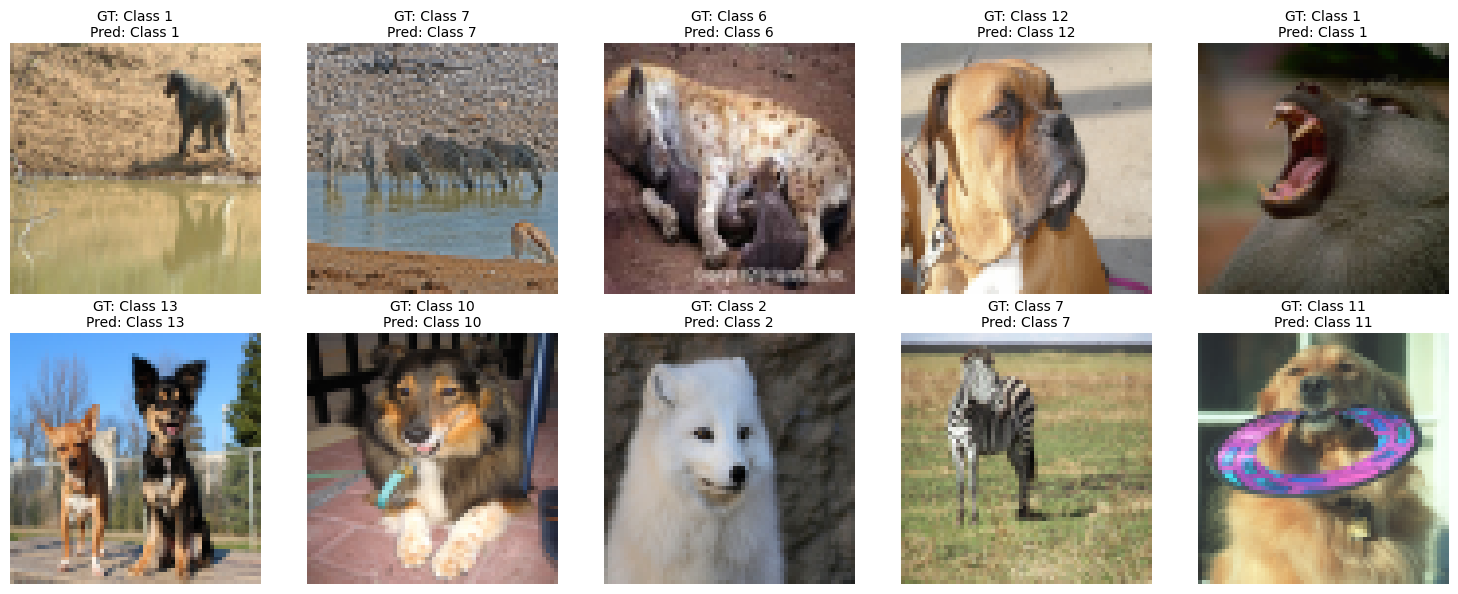

Epoch 8, Train Loss: 0.1874, Validation Loss: 0.3795, Validation Accuracy: 0.8813


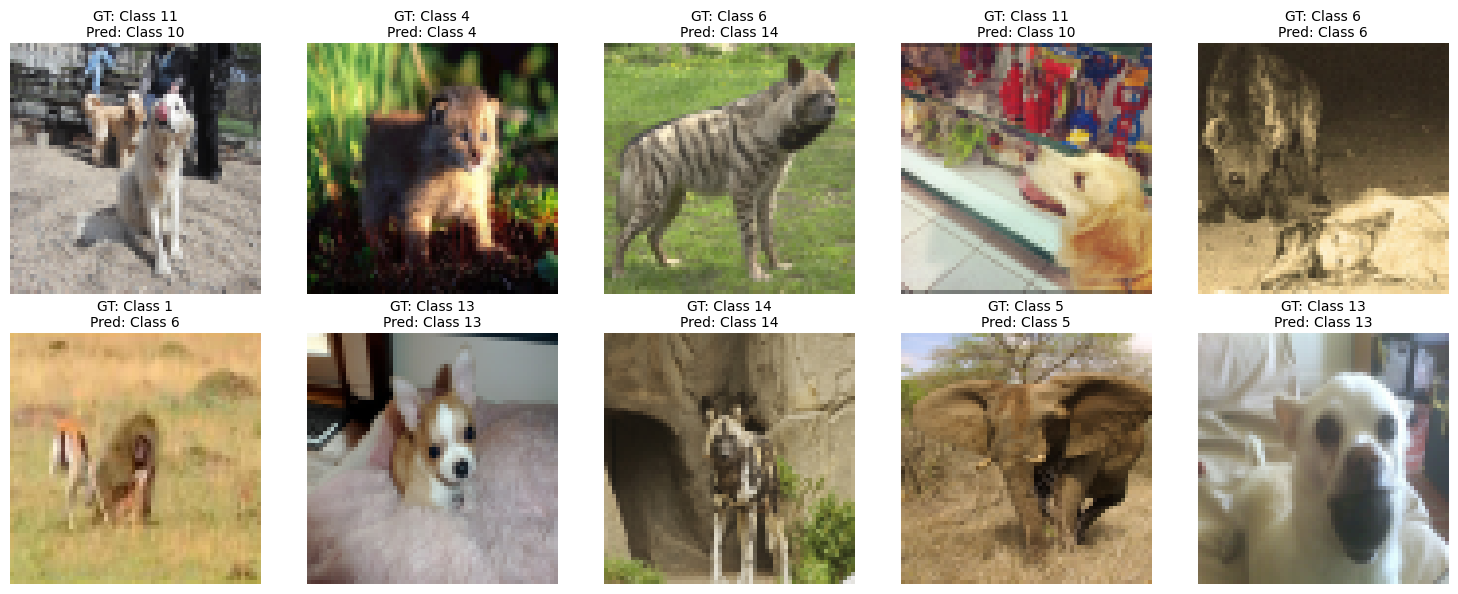

Epoch 9, Train Loss: 0.1714, Validation Loss: 0.3853, Validation Accuracy: 0.8840


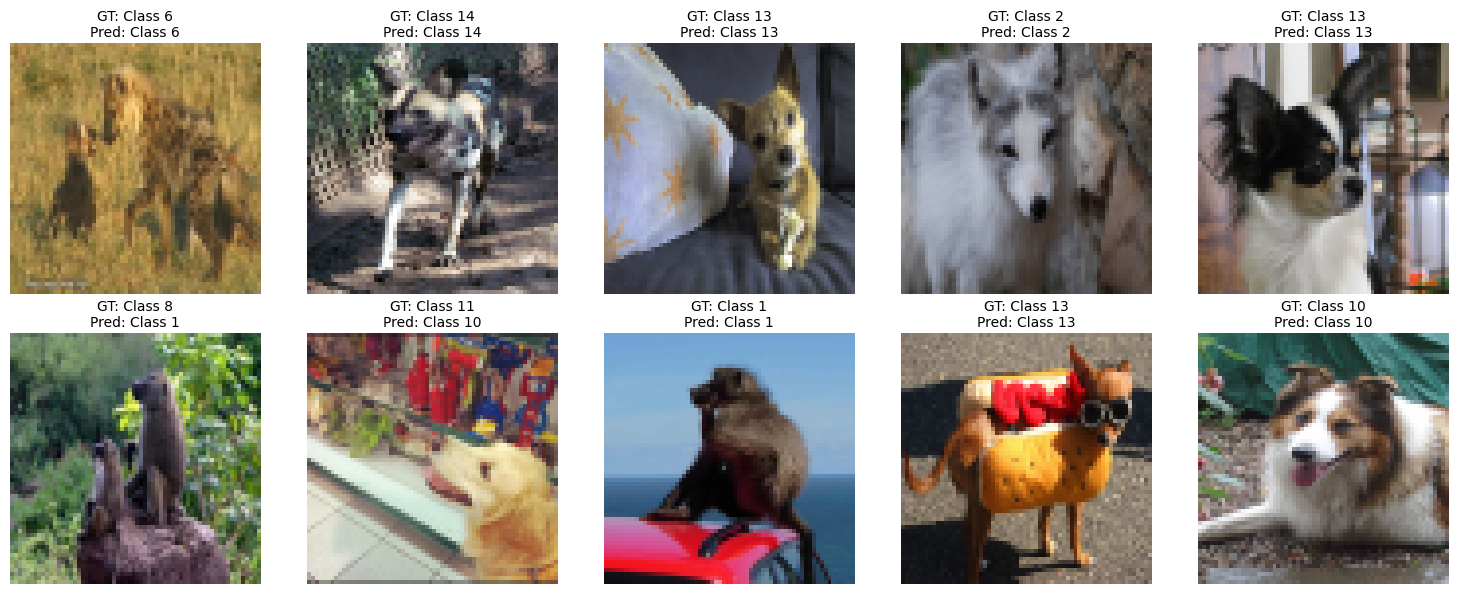

Epoch 10, Train Loss: 0.1473, Validation Loss: 0.3841, Validation Accuracy: 0.8800
Early stopping
Final Average Attention Weights (Contribution per model across all epochs):
Custom Model 1: 0.1847
Custom Model 2: 0.2040
Custom Model 3: 0.2048
Pretrained Model: 0.4064
Full Final Avg Attention Weights Matrix:
[[0.1886951  0.20657149 0.20948642 0.39524692]
 [0.17765146 0.2006138  0.1984666  0.42326805]
 [0.19132505 0.20912552 0.2095154  0.39003405]
 [0.18132547 0.19958334 0.20188105 0.41721016]]


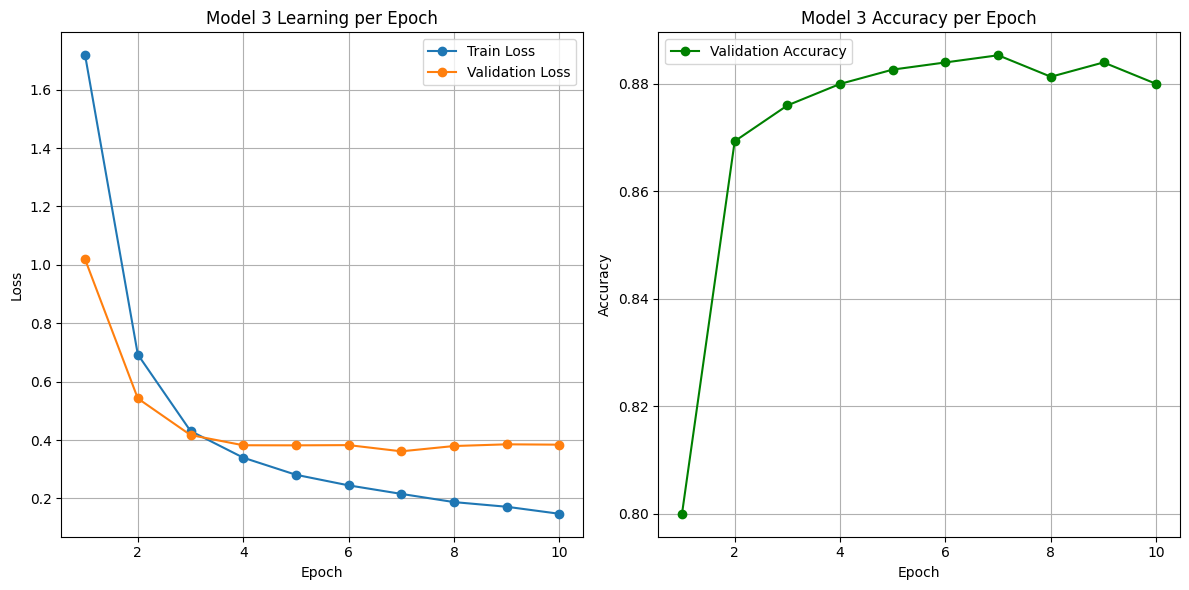

Model4 is saved to: /home/kimw30/CAS771/Task2_data/model4_all.pth


In [160]:
models = load_models()  # Load all models
fusion_model, optimizer, criterion = get_fusion_model(Ffusion_name, Finput_dim)
train_dataloader, test_dataloader = load_combined_dataset()

progress = get_cas771plot(fusion_model, criterion, device, train_dataloader, test_dataloader, FTest_dataset_num, models, Ffusion_name)
es = CAS771EarlyStopping()

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=FOpt_schedule_step, gamma=FOpt_schedule_rate) 
all_total_attn_weights = []  # 모든 에포크에 걸친 가중치 누적
# train combine model
for epoch in range(FEpoch):
    fusion_model.train()
    total_loss = 0
    progress.init_running_loss()
    total_attn_weights = []  # 가중치 누적용

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        embeddings = []
        poutputs = []
        with torch.no_grad():
            for model in models:
                embedding = model(inputs, return_embedding=True).to(device)
                if Ffusion_name == 'cf':
                    poutput = model(inputs, return_embedding=False).to(device)
                    poutputs.append(poutput)
                embeddings.append(embedding)
                

        if FSequential == True:
            for emb in embeddings:
                outputs = fusion_model(emb)
                loss = criterion(outputs, labels)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                progress.add_loss(loss.item())

                total_loss += loss.item()
        else: 
            # Fusion Network에 입력
            if Ffusion_name == 'ief' or Ffusion_name == 'ieaf':
                outputs = fusion_model(embeddings, inputs)
            elif Ffusion_name == 'afwp':
                preprocess = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
                inputs = preprocess(inputs)
                outputs, attn_weights = fusion_model(embeddings, inputs)
                # Attention 가중치 누적
                # 배치별 가중치를 평균 내어 (4, 4)로 통일
                avg_attn_weights_per_batch = attn_weights.mean(dim=0).detach().cpu().numpy()  # (4, 4)
                total_attn_weights.append(avg_attn_weights_per_batch)
            elif Ffusion_name == 'cf' or Ffusion_name == 'acf':
                outputs = fusion_model(embeddings, poutputs)
            else:
                outputs = fusion_model(embeddings)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            progress.add_loss(loss.item())

            total_loss += loss.item()
    
    if es.isStop(progress.append(epoch)):
        break 
    
    #scheduler.step() 
    # 에포크별 가중치 누적
    if total_attn_weights:  # afwp 모드일 경우에만
        avg_attn_weights = np.mean(total_attn_weights, axis=0)  # (4, 4) 평균 가중치
        all_total_attn_weights.append(avg_attn_weights)  # 모든 에포크에 걸친 평균 가중치 저장

# 훈련 종료 후 모든 에포크에 걸친 평균 가중치 출력
if all_total_attn_weights:
    final_avg_attn_weights = np.mean(all_total_attn_weights, axis=0)  # (4, 4)
    print("Final Average Attention Weights (Contribution per model across all epochs):")
    
    # 열 합계를 기준으로 기여도 계산
    contributions = np.sum(final_avg_attn_weights, axis=0)  # (4,)
    total_contribution = np.sum(contributions)
    normalized_contributions = contributions / total_contribution
    
    for i in range(4):
        model_name = f"Custom Model {i+1}" if i < 3 else "Pretrained Model"
        print(f"{model_name}: {normalized_contributions[i]:.4f}")
    print(f"Full Final Avg Attention Weights Matrix:\n{final_avg_attn_weights}")
else:
    print("No Attention weights recorded (not in afwp mode?)")

progress.plot()
save_model(fusion_model, 3, True)

del fusion_model
torch.cuda.empty_cache()  